#### 스태킹(Stacking)

- 스태킹은 여러 모델의 예측 결과를 메타 모델(meta-model)로 결합하는 방법
- 각 기본 모델(base model)이 예측한 결과를 새로운 데이터로 사용하여 메타 모델이 학습됨
- 기본 모델과 메타 모델이 서로 다른 알고리즘을 사용할 수 있음

![](https://velog.velcdn.com/images/newnew_daddy/post/53adabda-652c-4291-bf35-8306340b18bb/image.png)

#### 배깅 vs 부스팅 vs 스태깅

![](https://velog.velcdn.com/images/newnew_daddy/post/02139a3a-06cd-4fd9-b00e-40e3988ded13/image.png)


In [11]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# 조건에 맞는 데이터셋 생성
X, y = make_classification(
    n_samples=500,        # 샘플 수
    n_features=6,         # 총 특성 수
    n_informative=5,      # 정보 특성 수
    n_redundant=0,        # 중복 특성 수
    n_classes=5,          # 클래스 수
    n_clusters_per_class=1, # 각 클래스당 클러스터 수
    class_sep=1.8,        # 클래스 간의 구분 정도 (큰 값일수록 더 잘 구분됨)
    random_state=42
)

# DataFrame으로 변환
columns = [f'feature_{i}' for i in range(1, 7)]
df = pd.DataFrame(X, columns=columns)
df['target'] = y

# 각 컬럼의 스케일을 다르게 하기 위해 변환
scales = [1, 10, 100, 1000, 0.1, 0.01]
for i, scale in enumerate(scales):
    df[f'feature_{i+1}'] *= scale

# df.to_csv("sample_multiclass_dataset.csv", index=False)


#### StackingClassifier 메소드의 주요 인자 설명

```python
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

base_models = [
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
]

meta_model = LogisticRegression(max_iter=1000, random_state=42)

stacking_clf = StackingClassifier(
    estimators=base_models,       # 베이스 모델들의 리스트, 각 모델은 (이름, 객체) 형태
    final_estimator=meta_model,   # 메타 모델 (최종 예측을 수행할 모델)
    cv=5,                         # 교차 검증을 위한 폴드 수 (None일 경우 기본값으로 사용)
    stack_method='auto',          # 메타 모델을 학습하는 방법('predict_proba', 'decision_function', 'predict')
    passthrough=False,            # True로 설정 시, 베이스 모델의 원본 입력 데이터도 메타 모델에 전달
    verbose=0                     # 학습 과정의 진행 상황을 출력하는 정도 (0이면 출력 없음)
)
```

Decision Tree Accuracy: 0.84
SVC Accuracy: 0.8133333333333334
Stacked Model Accuracy: 0.8533333333333334


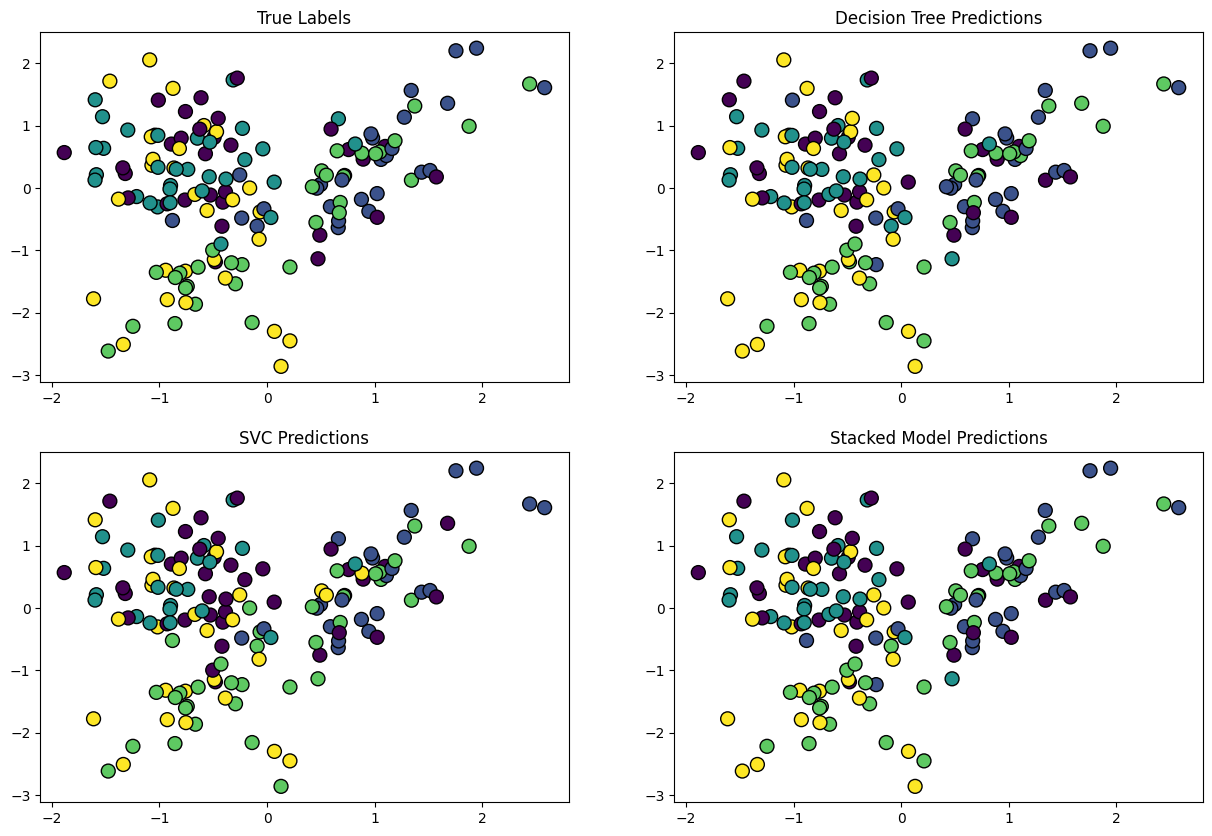

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 데이터 로드
# df = pd.read_csv('./dataset/sample_multiclass_dataset.csv')

X = df[df.columns[:-1]].values
y = df[df.columns[-1]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 기본 학습기 설정
base_learners = [
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('svc', SVC(kernel='linear', random_state=42, probability=True))
]

# 메타 학습기 설정
meta_learner = LogisticRegression()

# 스태킹 모델
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)
stacking_model.fit(X_train, y_train)

# 기본 학습기의 예측 결과
dt_predictions = stacking_model.named_estimators_['decision_tree'].predict(X_test)
svc_predictions = stacking_model.named_estimators_['svc'].predict(X_test)

# 메타 학습기의 최종 예측 결과
stacked_predictions = stacking_model.predict(X_test)

# 정확도 출력
print(f"Decision Tree Accuracy: {accuracy_score(y_test, dt_predictions)}")
print(f"SVC Accuracy: {accuracy_score(y_test, svc_predictions)}")
print(f"Stacked Model Accuracy: {accuracy_score(y_test, stacked_predictions)}")

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', edgecolor='k', s=100)
axes[0, 0].set_title("True Labels")

axes[0, 1].scatter(X_test[:, 0], X_test[:, 1], c=dt_predictions, cmap='viridis', edgecolor='k', s=100)
axes[0, 1].set_title("Decision Tree Predictions")

axes[1, 0].scatter(X_test[:, 0], X_test[:, 1], c=svc_predictions, cmap='viridis', edgecolor='k', s=100)
axes[1, 0].set_title("SVC Predictions")

axes[1, 1].scatter(X_test[:, 0], X_test[:, 1], c=stacked_predictions, cmap='viridis', edgecolor='k', s=100)
axes[1, 1].set_title("Stacked Model Predictions")

plt.show()

Logistic Regression Accuracy: 0.8933333333333333
Decision Tree Accuracy: 0.8666666666666667
SVC Accuracy: 0.9166666666666666
Stacked Model Accuracy: 0.9333333333333333


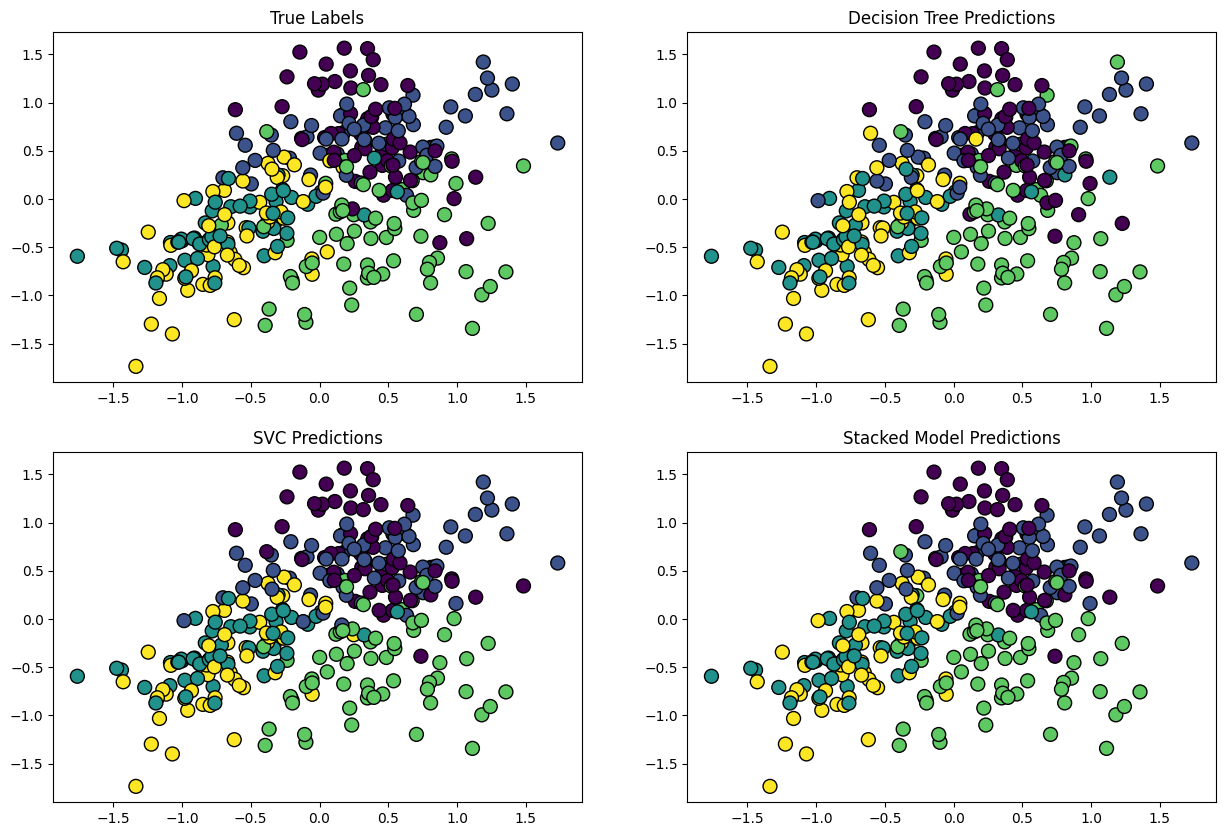

In [24]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# 조건에 맞는 데이터셋 생성
X, y = make_classification(
    n_samples=1000,        # 샘플 수
    n_features=6,         # 총 특성 수
    n_informative=5,      # 정보 특성 수
    n_redundant=0,        # 중복 특성 수
    n_classes=5,          # 클래스 수
    n_clusters_per_class=1, # 각 클래스당 클러스터 수
    class_sep=1.5,        # 클래스 간의 구분 정도 (큰 값일수록 더 잘 구분됨)
    random_state=42
)

# DataFrame으로 변환
columns = [f'feature_{i}' for i in range(1, 7)]
df = pd.DataFrame(X, columns=columns)
df['target'] = y

# 각 컬럼의 스케일을 다르게 하기 위해 변환
scales = [1, 10, 100, 1000, 0.1, 0.01]
for i, scale in enumerate(scales):
    df[f'feature_{i+1}'] *= scale

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 데이터 로드
# df = pd.read_csv('./dataset/sample_multiclass_dataset.csv')

X = df[df.columns[:-1]].values
y = df[df.columns[-1]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


sc = RobustScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# 기본 학습기 설정
base_learners = [
    ('lr', LogisticRegression(max_iter=500, random_state=42)),
    ('decision_tree', DecisionTreeClassifier(random_state=42)),
    ('svc', SVC(kernel='linear', random_state=42, probability=True))
]

# 메타 학습기 설정
meta_learner = LogisticRegression()

# 스태킹 모델
stacking_model = StackingClassifier(estimators=base_learners, final_estimator=meta_learner)
stacking_model.fit(X_train, y_train)

# 기본 학습기의 예측 결과
lr_predictions = stacking_model.named_estimators_['lr'].predict(X_test)
dt_predictions = stacking_model.named_estimators_['decision_tree'].predict(X_test)
svc_predictions = stacking_model.named_estimators_['svc'].predict(X_test)

# 메타 학습기의 최종 예측 결과
stacked_predictions = stacking_model.predict(X_test)

# 정확도 출력
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, lr_predictions)}")
print(f"Decision Tree Accuracy: {accuracy_score(y_test, dt_predictions)}")
print(f"SVC Accuracy: {accuracy_score(y_test, svc_predictions)}")
print(f"Stacked Model Accuracy: {accuracy_score(y_test, stacked_predictions)}")

# 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='viridis', edgecolor='k', s=100)
axes[0, 0].set_title("True Labels")

axes[0, 1].scatter(X_test[:, 0], X_test[:, 1], c=dt_predictions, cmap='viridis', edgecolor='k', s=100)
axes[0, 1].set_title("Decision Tree Predictions")

axes[1, 0].scatter(X_test[:, 0], X_test[:, 1], c=svc_predictions, cmap='viridis', edgecolor='k', s=100)
axes[1, 0].set_title("SVC Predictions")

axes[1, 1].scatter(X_test[:, 0], X_test[:, 1], c=stacked_predictions, cmap='viridis', edgecolor='k', s=100)
axes[1, 1].set_title("Stacked Model Predictions")

plt.show()
